# classification models

train Perceptron model using **scikit-learn** API instead of creating API ourselves in the guide *simple-classification-algorithms*.

In [1]:
from sklearn import datasets
import numpy as np

In [2]:
iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target
print('class label:', np.unique(y))

class label: [0 1 2]


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
def std_preprocessing(X, y, test_size=0.3, seed=1):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
    ss = StandardScaler()
    X_train_std = ss.fit_transform(X_train)
    X_test_std = ss.transform(X_test)
    return X_train_std, X_test_std, y_train, y_test

In [5]:
X_train_std, X_test_std, y_train, y_test = std_preprocessing(X, y)

train Perceptron model. due to its OvR (one-versus-rest) algorithm, scikit-learn supports multiclass classification.

In [6]:
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score

In [7]:
ppn = Perceptron(eta0=0.1, random_state=1)
ppn.fit(X_train_std, y_train)
y_pred = ppn.predict(X_test_std)
print('test accuracy: %.3f' % accuracy_score(y_true=y_test, y_pred=y_pred))
# print('test accuracy: %.3f' % ppn.score(X_test_std, y_test))

test accuracy: 0.978


In [8]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_decision_boundary(X, y, classifier, step=0.02):
    markers = ("s", "x", "o", "^", "v")
    colors = ["red", "blue", "lightgreen", "gray", "cyan"]
    cmap = ListedColormap(colors[:len(np.unique(y))])

    x1_min, x1_max = X[:, 0].min(), X[:, 0].max()
    x2_min, x2_max = X[:, 1].min(), X[:, 1].max()
    # np.meshgrid returns coordinate matrices from coordinate vectors
    x1_coordinates, x2_coordinates = np.meshgrid(np.arange(x1_min - 1, x1_max + 1, step),
                                                 np.arange(x2_min - 1, x2_max + 1, step))
    # transpose an array using np.array.T
    Z = classifier.predict(np.array([x1_coordinates.ravel(), x2_coordinates.ravel()]).T)
    Z = Z.reshape(x1_coordinates.shape)
    plt.contourf(x1_coordinates, x2_coordinates, Z, alpha=0.3, cmap=cmap)
    plt.xlim(x1_coordinates.min(), x1_coordinates.max())
    plt.ylim(x2_coordinates.min(), x2_coordinates.max())

    for idx, cl in enumerate(np.unique(y)):
        # boolean masking
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1], alpha=0.8, c=colors[idx], marker=markers[idx], label=cl)

visualize decision boundary of iris dataset carried out by scikit-learn Perceptron model.

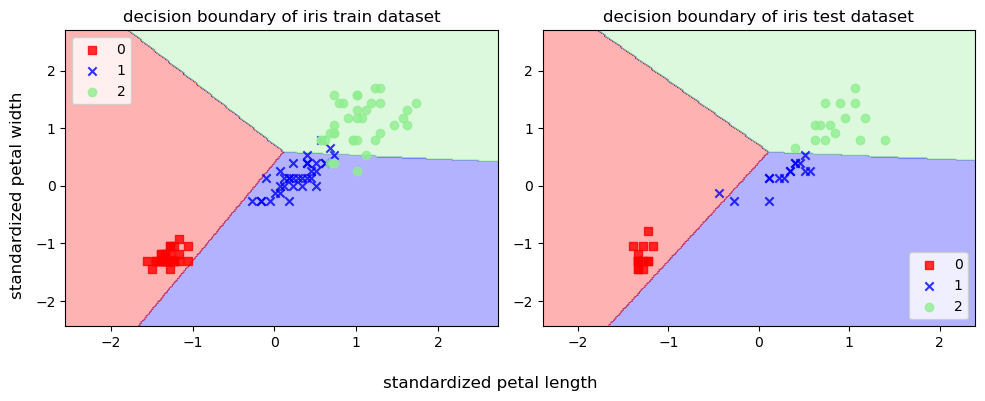

In [18]:
fig = plt.figure(figsize=(10, 4))
fig.supxlabel("standardized petal length")
fig.supylabel("standardized petal width")

plt.subplot(1, 2, 1)
plot_decision_boundary(X_train_std, y_train, classifier=ppn)
plt.title("decision boundary of iris train dataset")
plt.legend(loc="upper left")
plt.tight_layout()

plt.subplot(1, 2, 2)
plot_decision_boundary(X_test_std, y_test, classifier=ppn)
plt.title("decision boundary of iris test dataset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

visualize how **sigmoid function** looks like and understand the concept of logistic regression.

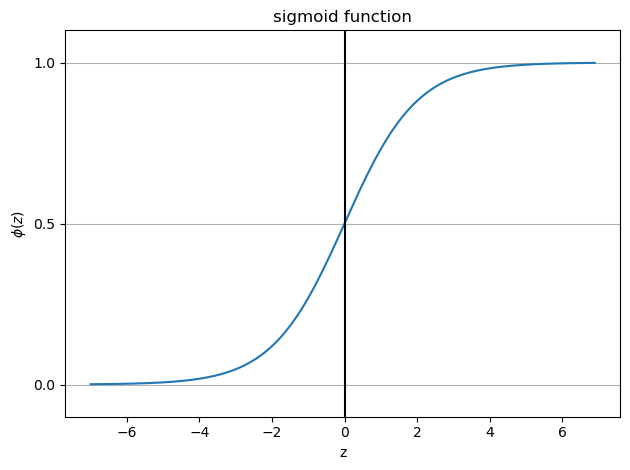

In [11]:
def sigmoid(z):
    return 1.0 / (1 + np.exp(-z))

z = np.arange(-7, 7, 0.1)
phi_z = sigmoid(z)
plt.plot(z, phi_z)
plt.axvline(0.0, color="k")
plt.ylim((-0.1, 1.1))
plt.title("sigmoid function")
plt.xlabel("z")
plt.ylabel("$\phi (z)$")
plt.yticks([0.0, 0.5, 1.0])
ax = plt.gca()
ax.yaxis.grid(True)
plt.tight_layout()
plt.show()

visualize the **loss function** of the logistic regression. this indicates that if the output prediction is correct, there will be a zero cost (means no update on weights). However if it misses, there will be a huge penalization accordingly.

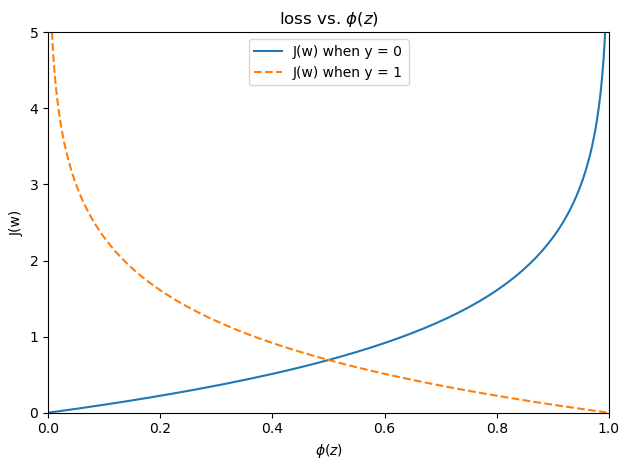

In [12]:
def loss_0(z):
    return -np.log(1-sigmoid(z))
def loss_1(z):
    return -np.log(sigmoid(z))

z = np.arange(-10, 10, 0.1)
phi_z = sigmoid(z)
l_0 = [loss_0(l) for l in z]
plt.plot(phi_z, l_0, label="J(w) when y = 0")
l_1 = [loss_1(l) for l in z]
plt.plot(phi_z, l_1, label="J(w) when y = 1", linestyle='--')
plt.xlim((0, 1))
plt.ylim((0, 5))
plt.title("loss vs. $\phi (z)$")
plt.xlabel("$\phi (z)$")
plt.ylabel("J(w)")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

create a **LogisticRegression** API.

In [14]:
class LogisticRegression(object):
    """
    lr: learning rate
    epochs: number of iterations
    random_state: seed
    """
    def __init__(self, lr=0.03, epochs=1000, random_state=1):
        self.lr = lr
        self.epochs = epochs
        self.random_state = random_state
    
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        w_size = 1 + X.shape[1]
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=w_size)
        self.cost_ = []
        for _ in range(self.epochs):
            net_input = self.net_input(X)
            output = self.activation(net_input)
            errors = (y - output)
            self.w_[1:] += self.lr * X.T.dot(errors)
            self.w_[0] += self.lr * errors.sum()
            cost = (-y.dot(np.log(output)) - (1-y).dot(np.log(1-output)))
            self.cost_.append(cost)
        return self
    
    def net_input(self, X):
        return np.dot(X, self.w_[1:]) + self.w_[0]
    
    def activation(self, z):
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))
    
    def predict(self, X):
        return np.where(self.net_input(X) >= 0.0, 1, 0)

apply logistic regression model on the iris dataset (only binary classification is applicable here).

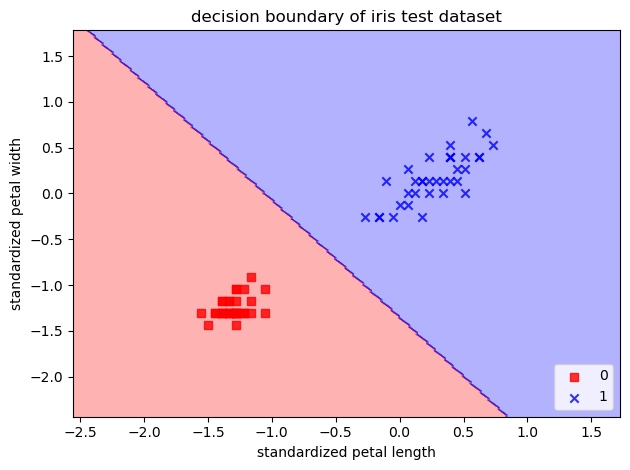

In [19]:
X_train_std_bi = X_train_std[(y_train == 0) | (y_train == 1)]
y_train_bi = y_train[(y_train == 0) | (y_train == 1)]

logistic = LogisticRegression()
logistic.fit(X_train_std_bi, y_train_bi)
plot_decision_boundary(X_train_std_bi, y_train_bi, classifier=logistic)
plt.title("decision boundary of iris test dataset")
plt.xlabel("standardized petal length")
plt.ylabel("standardized petal width")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

train logistic regression model using scikit-learn API.

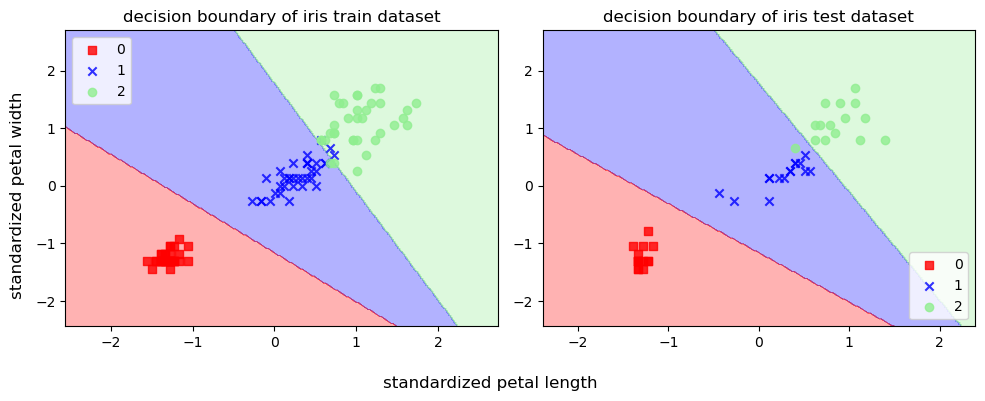

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=100.0, random_state=1)
lr.fit(X_train_std, y_train)
fig = plt.figure(figsize=(10, 4))
fig.supxlabel("standardized petal length")
fig.supylabel("standardized petal width")

plt.subplot(1, 2, 1)
plot_decision_boundary(X_train_std, y_train, classifier=lr)
plt.title("decision boundary of iris train dataset")
plt.legend(loc="upper left")
plt.tight_layout()

plt.subplot(1, 2, 2)
plot_decision_boundary(X_test_std, y_test, classifier=lr)
plt.title("decision boundary of iris test dataset")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

print out the test accuracy of logistic regression model on iris dataset.

In [22]:
print("test accuracy: %.3f" % lr.score(X_test_std, y_test))

test accuracy: 0.978


display the prediction of first 5 test samples. Then, using `argmax` function to return the class label of maximum value in each row. the index of the array corresponds to the class label of iris dataset.

In [23]:
lr.predict_proba(X_test_std[:5, :])

array([[1.52213484e-12, 3.85303417e-04, 9.99614697e-01],
       [9.93560717e-01, 6.43928295e-03, 1.14112016e-15],
       [9.98655228e-01, 1.34477208e-03, 1.76178271e-17],
       [3.79431985e-06, 9.04401285e-01, 9.55949212e-02],
       [5.22212406e-05, 9.94209099e-01, 5.73867966e-03]])

In [24]:
lr.predict_proba(X_test_std[:5, :]).argmax(axis=1)
# lr.predict(X_test_std[:5, :])

array([2, 0, 0, 1, 1], dtype=int64)

## Support Vector Machine

Support vector machine (SVM) tries to maximize the **margin** which is the distance between decision boundary $w^Tx = 0$ and samples that are closest to each class's hyperplane (eg. -1 and 1). Those samples are called **support vectors**. The reason for finding a large margin of decision boundary is that it tends to do generalization better on the dataset and reduces errors. Small margin will eventually make the classification model become ovefitting.

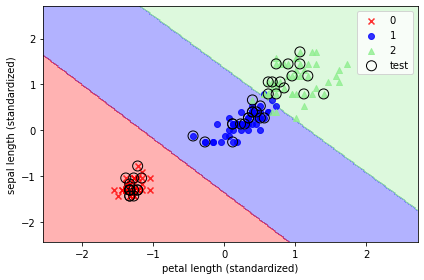

In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=1.0, random_state=1)
svm.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))

display_decision_boundary(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length (standardized)')
plt.ylabel('sepal length (standardized)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

One of the reasons why SVM algorithm is popular is that it can also able to handle the non-linear classification problem using a **kernel SVM method**.

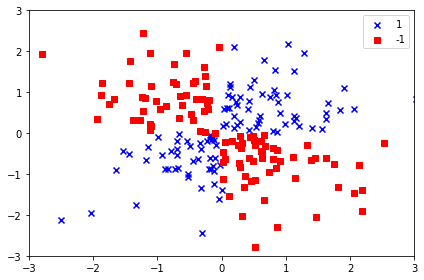

In [14]:
# non-linear dataset
np.random.seed(1)
X_xor = np.random.randn(200, 2)
y_xor = np.logical_xor(X_xor[:, 0] > 0, X_xor[:, 1] > 0)
y_xor = np.where(y_xor, -1, 1)

plt.scatter(
    X_xor[y_xor == 1, 0],
    X_xor[y_xor == 1, 1],
    c = 'b',
    marker='x',
    label='1'
)
plt.scatter(
    X_xor[y_xor == -1, 0],
    X_xor[y_xor == -1, 1],
    c = 'r',
    marker='s',
    label='-1'
)
plt.xlim([-3, 3])
plt.ylim([-3, 3])
plt.legend(loc='best')
plt.tight_layout()
plt.show()

A kernel SVM method utilizes mapping function $\phi$ to project the non-linear data to a higher dimensional space where a linear SVM model then can able to classify the projected data in a new dimensional space. After training the model, the projected data is transformed back to the original dimensional space using a same mapping function $\phi$ and we can use a trained model for classification after that. However, the computation of mapping function $\phi$ for projecting the non-linear data to a higher dimensional space and vice versa is extremely complicated and cost-consuming. Therefore, we use so-called a **kernel trick** to reduce the cost of dot product computation between two samples in a higher dimensional space.

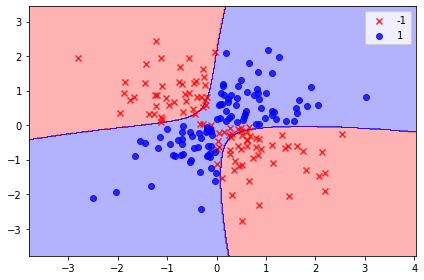

In [15]:
# RBF stands for Radial Basis Function
# gamma is a parameter for limiting Gaussian sphere
svm = SVC(kernel='rbf', random_state=1, gamma=0.1, C=10.0)
svm.fit(X_xor, y_xor)
display_decision_boundary(X_xor, y_xor, classifier=svm)
plt.legend(loc='best')
plt.tight_layout()
plt.show()

A kernel SVM method on the iris flower dataset also performs pretty well.

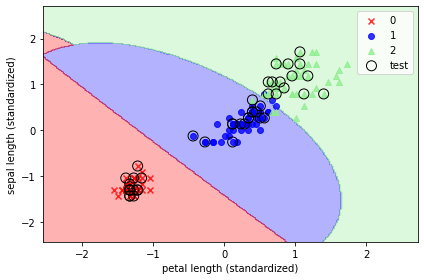

In [16]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.2, C=10.0)
svm.fit(X_train_std, y_train)
display_decision_boundary(X_combined_std, y_combined, classifier=svm, test_idx=range(105, 150))
plt.xlabel('petal length (standardized)')
plt.ylabel('sepal length (standardized)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Decision Tree and Random Forest

Decision tree is a **process of making decisions based on the features** to classify the labels of given samples. The objective function of decision tree algorithm is to decide which features to use in each node, so that to maximize the **information gain**. The information gain (IG) is defined as follows: 
<br><center>$IG(D_p, f) = I(D_p) - \sum_{j=1}^m {N_j \over N_p} I(D_j)$ where $f = $ feature, $D_p, D_j = $ dataset of parent and $j$-th child node and $I = $ **impurity**.</center>

There are three impurity parameters (decision rules) known as **gini impurity**, **entropy** and **classification error**. For more information about the decision tree algorithm, visit [scikit-learn.org about Decision Tree](https://scikit-learn.org/stable/modules/tree.html).

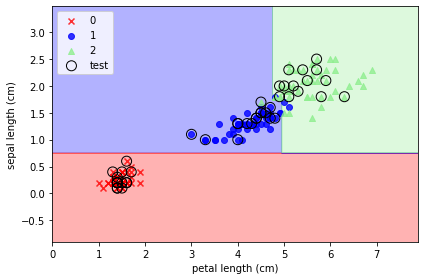

In [17]:
from sklearn.tree import DecisionTreeClassifier

# pruning the tree by setting the max depth of the tree equals to 4
tree_model = DecisionTreeClassifier(criterion='gini', max_depth=4, random_state=1) # use gini impurity
tree_model.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
display_decision_boundary(X_combined, y_combined, classifier=tree_model, test_idx=range(105, 150))
plt.xlabel('petal length (cm)')
plt.ylabel('sepal length (cm)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

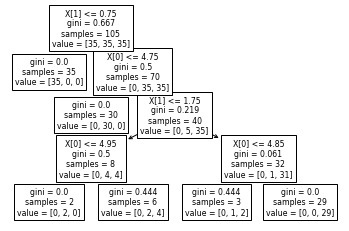

In [18]:
from sklearn import tree

tree.plot_tree(tree_model)
plt.show()

Random forest is an **ensemble** of decision tree algorithm. Simply, the step-by-step guide of a random forest algorithm is as follows:
1. Take $n$ random bootstrap samples **with replacement**. $n$ is normally equal to the **number of samples**.
2. In each node, train a decision tree model using $n$ bootstrap samples. Choose random $d$ features **without replacement**. $d$ is normally equal to the **square root of features**. Then, make decisions based on the objective function to maximize the information gain.
3. Repeat step 1 and 2 $k$ times. $k$ is the only hyperparameter you have to choose.
4. Make an average of all decision trees. (eg. majority voting)

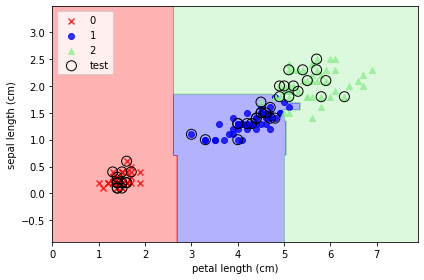

In [19]:
from sklearn.ensemble import RandomForestClassifier

# use 25 decision trees with gini impurity
forest = RandomForestClassifier(criterion='gini', n_estimators=25, random_state=1, n_jobs=-1)
forest.fit(X_train, y_train)
display_decision_boundary(X_combined, y_combined, classifier=forest, test_idx=range(105, 150))
plt.xlabel('petal length (cm)')
plt.ylabel('sepal length (cm)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

## Lazy Learner: K-Nearest Neighbors

Unlike previous classification models, the k-nearest neighbors (KNN) algorithm is a **non-parametric**, **instance-based** model where it stores all the training dataset instead of learning from it. Therefore, a KNN algorithm does not require any computation resources. This kind of algorithm is typically referred to as a family of **lazy learning**. For more information about the K-nearest neighbors, visit [IBM Analytics about KNN](https://www.ibm.com/topics/knn).


A simple steps of KNN algorithm are as follows:
1. Determine the value $k$ and the distance metric.
2. Find $k$ neighbors. The value $k$ is the number of neighbors around a specific query point to use to determine the class label of that point.
3. After a majority vote, allocate the class label of a query point.

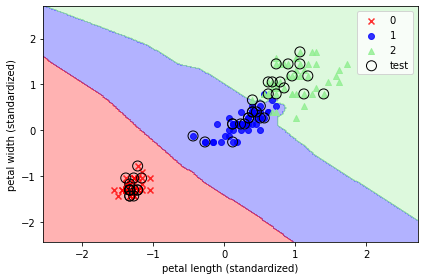

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# minkowski distance is the generalized form of euclidean and manhattan distance metrics
# set p=2 to use euclidean distance, p=1 for manhattan distance
knn = KNeighborsClassifier(n_neighbors=5, p=2, metric='minkowski')
knn.fit(X_train_std, y_train)

X_combined_std = np.vstack((X_train_std, X_test_std))
y_combined = np.hstack((y_train, y_test))
display_decision_boundary(X_combined_std, y_combined, classifier=knn, test_idx=range(105, 150))
plt.xlabel('petal length (standardized)')
plt.ylabel('petal width (standardized)')
plt.legend(loc='best')
plt.tight_layout()
plt.show()